[View in Colaboratory](https://colab.research.google.com/github/micheledw/hub/blob/master/mkr_sept12.ipynb)

In [73]:
%reset
#%cd RankNet
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn
!pip3 install --quiet chainer
#!pip3 install --quiet net
import pandas 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import numpy as np
from chainer import Variable, optimizers
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import json
nltk.download('punkt')
from keras import backend
from keras.layers import Activation, Dense, Input, Subtract
from keras.models import Model






Once deleted, variables cannot be recovered. Proceed (y/[n])? y
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
np.random.seed(0)
n_dim = 5
n_rank = 5
n_sample = 8
sigma = 5.
n_iter = 20
n_hidden = 5
loss_step = 1
train_ndcgs = []
test_ndcgs = []

In [75]:
#!git clone 'https://github.com/szdr/RankNet.git'
%cd RankNet

import net

[Errno 2] No such file or directory: 'RankNet'
/content/RankNet


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
  

In [0]:
embed = hub.Module(module_url)

In [0]:
datastore=!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
############################3this command will load the first question in the first paragraph


with open("train-v2.0.json", 'r') as f:
     datastore = json.load(f)


############################3this command will load the first question in the first paragraph
sentence =datastore['data'][0]['paragraphs'][0]['qas'][1]['question']

################### this will parse the context paragph to different sentences
paragraph=datastore['data'][0]['paragraphs'][0]['context']
words = []
separators = ['.',',',':',';']
oldValue = 0
for value in range(len(paragraph)):
    if paragraph[value] in separators:
        words.append(paragraph[oldValue:value+1])
        oldValue = value+2
#####divide the paragrpah into senetnces"
from nltk import tokenize
tf.logging.set_verbosity(tf.logging.ERROR)
a5=tokenize.sent_tokenize(paragraph)


In [0]:
###### calculate the similarity using an encoder
for i in a5:
   messages = [sentence, i]
   with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        message_embeddings = session.run(embed(messages))
  
  
 


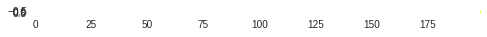

In [88]:
import matplotlib.pyplot as plt
import numpy as np


plt.imshow((message_embeddings[1:200,1:200]), cmap='hot', interpolation='nearest')
plt.show()

In [0]:
print(message_embeddings[1:200,1:200])

In [0]:
n_sample=512
def make_dataset(n_dim, n_rank, n_sample, sigma):
    #w = np.random.randn(n_dim)
      X=message_embeddings
    #X = np.array(X).astype(np.float32)
      ys = np.random.random_integers(4, size=n_sample)
      ys = np.inner(message_embeddings, message_embeddings)
   # ys = np.reshape(np.array(ys), (-1, 1))
      return X, ys
  
  



In [0]:
def ndcg(y_true, y_score, k=100):
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    y_true_sorted = sorted(y_true, reverse=True)
    ideal_dcg = 0
    for i in range(k):
        ideal_dcg += (2 ** y_true_sorted[i] - 1.) / np.log2(i + 2)
    dcg = 0
    argsort_indices = np.argsort(y_score)[::-1]
    for i in range(k):
        dcg += (2 ** y_true[argsort_indices[i]] - 1.) / np.log2(i + 2)
    ndcg = dcg / ideal_dcg
    return ndcg

In [0]:
if __name__ == '__main__':
    np.random.seed(0)
    n_dim = 4
    n_rank = 5
    n_sample = 512
    sigma = 5.
    X, ys = make_dataset(n_dim, n_rank, n_sample, sigma)
    X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.33)

    n_iter = 2000
    n_hidden = 50
    loss_step = 50
    N_train = np.shape(X_train)[0]

    model = net.RankNet(net.MLP(n_dim, n_hidden))
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    N_train = np.shape(X_train)[0]
    train_ndcgs = []
    test_ndcgs = []
    for step in range(n_iter):
        i, j = np.random.randint(N_train, size=2)
        x_i = Variable(X_train[i].reshape(1, -1))
        print(x_i.shape)
       # print(x_i)
        x_j = Variable(X_train[j].reshape(1, -1))
      #  print(x_j.shape)
        y_i = Variable(y_train[i])
       # print(y_i.shape)
        y_j = Variable(y_train[j])
        #print(y_j)
        model.zerograds()
        loss = model(x_i, x_j, y_i, y_j)
        loss.backward()
        optimizer.update()
        if (step + 1) % loss_step == 0:
            train_score = model.predictor(Variable(X_train))
            test_score = model.predictor(Variable(X_test))
            train_ndcg = ndcg(y_train, train_score.data)
            test_ndcg = ndcg(y_test, test_score.data)
            train_ndcgs.append(train_ndcg)
            test_ndcgs.append(test_ndcg)
           # print("step: {}".format(step + 1))
           # print("NDCG@100 | train: {}, test: {}".format(
            #    train_ndcg, test_ndcg))

    sns.set_context("poster")
    plt.plot(train_ndcgs, label="Train")
    plt.plot(test_ndcgs, label="Test")
    xx = np.linspace(0, n_iter / loss_step, num=n_iter / loss_step + 1)
    labels = np.arange(loss_step, n_iter + 1, loss_step)
    plt.xticks(xx, labels, rotation=45)
    plt.legend(loc="best")
    plt.xlabel("step")
    plt.ylabel("NDCG@100")
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
!ls

RankNet  sample_data  train-v2.0.json  train-v2.0.json.1  wget-log  wget-log.1
